In [1]:
from utils import balance_sample, univariate_classifier

import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as pgo
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)


from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
)
from sklearn.ensemble import ExtraTreesClassifier

from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import multipletests

Using MNE with API > 0.19


In [2]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 2  # width in inches
fig_height = 8  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1.5,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
        'figure.figsize': fig_size
    },
)

sns.set_palette(sns.color_palette(nt_colors))

# Load Data

In [4]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [13]:
df = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df = df.append(df_)
    
# df.to_csv('Data/all_markers.csv')

In [14]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'b', 'b_n', 'g', 'g_n', 't', 't_n',
       'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b']
erps =['CNV', 'P1', 'P3a', 'P3b']


df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df_markers
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial <= 4')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )
df_markers.to_csv('Data/all_markers.csv')

In [22]:
df_subtracted

,participant,wSMI_1,wSMI_2,wSMI_4,wSMI_8,p_e_1,p_e_2,p_e_4,p_e_8,k,...,a,events,label,probe,mind,stimuli,correct,prev_trial,segment,epoch_type
0,0,0.035046,0.034423,0.059453,0.108725,0.841968,0.879359,0.907700,0.917130,0.777939,...,-105.651639,11117000.0,"['PC', 'on-task', 'go', 'correct', '7', 's000']",PC,on-task,go,correct,7,s000,evoked
1,0,0.034691,0.032886,0.054962,0.105909,0.831561,0.880937,0.911877,0.919441,0.777628,...,-106.673999,11116000.0,"['PC', 'on-task', 'go', 'correct', '6', 's000']",PC,on-task,go,correct,6,s000,evoked
2,0,0.034628,0.034041,0.053220,0.112560,0.817744,0.891026,0.886795,0.931884,0.776076,...,-105.414218,11115000.0,"['PC', 'on-task', 'go', 'correct', '5', 's000']",PC,on-task,go,correct,5,s000,evoked
3,0,0.038615,0.034593,0.052643,0.114609,0.825328,0.864688,0.882979,0.930129,0.768833,...,-104.947151,11113000.0,"['PC', 'on-task', 'go', 'correct', '3', 's000']",PC,on-task,go,correct,3,s000,evoked
4,0,0.035308,0.032871,0.055452,0.107962,0.798895,0.861135,0.901788,0.923021,0.770488,...,-104.974142,11112000.0,"['PC', 'on-task', 'go', 'correct', '2', 's000']",PC,on-task,go,correct,2,s000,evoked
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,25,0.029308,0.033936,0.057424,0.112129,0.706514,0.814749,0.910044,0.967345,0.765108,...,-95.611685,25017033.0,"['SC', 'sMW', 'nogo', 'correct', '7', 's033']",SC,sMW,nogo,correct,7,s033,evoked
168,25,0.029229,0.032199,0.058104,0.109385,0.769796,0.876753,0.901882,0.926944,0.766970,...,-99.023488,25013034.0,"['SC', 'sMW', 'nogo', 'correct', '3', 's034']",SC,sMW,nogo,correct,3,s034,evoked
169,25,0.028850,0.032525,0.053026,0.117343,0.762373,0.851092,0.914535,0.946939,0.762831,...,-96.105598,25013036.0,"['SC', 'sMW', 'nogo', 'correct', '3', 's036']",SC,sMW,nogo,correct,3,s036,evoked
170,25,0.029225,0.032574,0.060541,0.111821,0.730709,0.820878,0.886763,0.951059,0.746792,...,-94.622326,25012039.0,"['SC', 'sMW', 'nogo', 'correct', '2', 's039']",SC,sMW,nogo,correct,2,s039,evoked


# By Subject Univariate analyses 

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [6]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .groupby(['mind2', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_mind.drop(markers, axis=1).columns})

df_mind = (df_mind
    .groupby(['mind2', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
)

df_mind.columns = df_mind.columns.map("_".join)
df_mind  = df_mind.rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_first':'mind2'})
df_mind = balance_sample(df_mind, 'participant', 'mind2', levels = 2).drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also

AUC wSMI_1_mean = 0.44444444444444453 WilcoxonResult(statistic=18.0, pvalue=0.10986328125)
AUC wSMI_1_std = 0.4375 WilcoxonResult(statistic=28.0, pvalue=0.423828125)
AUC wSMI_2_mean = 0.4583333333333333 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC wSMI_2_std = 0.4513888888888889 WilcoxonResult(statistic=31.0, pvalue=0.5693359375)
AUC wSMI_4_mean = 0.3888888888888889 WilcoxonResult(statistic=27.0, pvalue=0.38037109375)
AUC wSMI_4_std = 0.46527777777777773 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC wSMI_8_mean = 0.45833333333333337 WilcoxonResult(statistic=29.0, pvalue=0.4697265625)
AUC wSMI_8_std = 0.3680555555555556 WilcoxonResult(statistic=23.0, pvalue=0.2333984375)
AUC p_e_1_mean = 0.5138888888888888 WilcoxonResult(statistic=35.0, pvalue=0.791015625)
AUC p_e_1_std = 0.4305555555555556 WilcoxonResult(statistic=23.0, pvalue=0.2333984375)
AUC p_e_2_mean = 0.5277777777777778 WilcoxonResult(statistic=29.0, pvalue=0.4697265625)
AUC p_e_2_std = 0.48611111111111116 

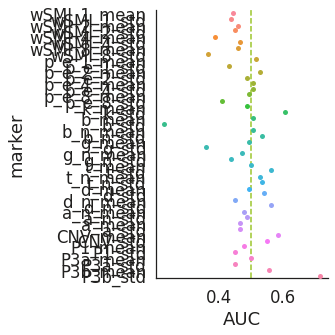

In [7]:
AUC = []
significants = []

for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = ot, y = mw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = ot, y = mw).pvalue < 0.05:
        significants.append(i)

print(f'List of significant markers: {significants}')

subject_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = subject_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_1_mean = 0.6458333333333333
AUC wSMI_1_std = 0.7361111111111112
AUC wSMI_2_mean = 0.6944444444444444
AUC wSMI_2_std = 0.6944444444444444
AUC wSMI_4_mean = 0.24305555555555558
AUC wSMI_4_std = 0.5972222222222222
AUC wSMI_8_mean = 0.6597222222222222
AUC wSMI_8_std = 0.763888888888889
AUC p_e_1_mean = 0.5972222222222222
AUC p_e_1_std = 0.6180555555555556
AUC p_e_2_mean = 0.5902777777777778
AUC p_e_2_std = 0.6180555555555556
AUC p_e_4_mean = 0.6041666666666667
AUC p_e_4_std = 0.7083333333333334
AUC p_e_8_mean = 0.611111111111111
AUC p_e_8_std = 0.6666666666666667
AUC k_mean = 0.5833333333333334
AUC k_std = 0.7534722222222222
AUC b_mean = 0.5763888888888888
AUC b_std = 0.20833333333333334
AUC b_n_mean = 0.7743055555555556
AUC b_n_std = 0.20833333333333334
AUC g_mean = 0.6041666666666667
AUC g_std = 0.6805555555555556
AUC g_n_mean = 0.5902777777777778
AUC g_n_std = 0.6388888888888888
AUC t_mean = 0.5763888888888888
AUC t_std = 0.7291666666666666
AUC t_n_mean = 0.6736111111111112
AUC

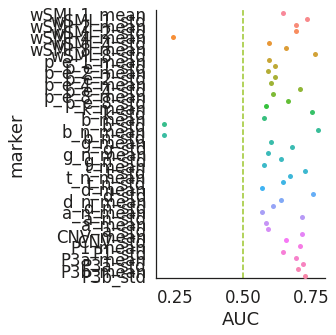

In [27]:
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [10]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['mind', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_mw.drop(markers, axis=1).columns})

df_mw = (df_mw
    .groupby(['mind', 'participant'], as_index = False).agg(agg_dict)
)
df_mw = balance_sample(df_mw, 'participant', 'mind', levels = 2).drop(['participant', 'probe','segment'], axis = 1) 


AUC wSMI_1 = 0.5234375 WilcoxonResult(statistic=68.0, pvalue=1.0)
AUC wSMI_2 = 0.390625 WilcoxonResult(statistic=45.0, pvalue=0.252227783203125)
AUC wSMI_4 = 0.515625 WilcoxonResult(statistic=50.0, pvalue=0.375457763671875)
AUC wSMI_8 = 0.53515625 WilcoxonResult(statistic=64.0, pvalue=0.860260009765625)
AUC p_e_1 = 0.52734375 WilcoxonResult(statistic=56.0, pvalue=0.5618896484375)
AUC p_e_2 = 0.5390625 WilcoxonResult(statistic=40.0, pvalue=0.1590576171875)
AUC p_e_4 = 0.5 WilcoxonResult(statistic=68.0, pvalue=1.0)
AUC p_e_8 = 0.484375 WilcoxonResult(statistic=44.0, pvalue=0.231201171875)
AUC k = 0.5390625 WilcoxonResult(statistic=53.0, pvalue=0.4637451171875)
AUC b = 0.5078125 WilcoxonResult(statistic=61.0, pvalue=0.743560791015625)
AUC b_n = 0.515625 WilcoxonResult(statistic=59.0, pvalue=0.668548583984375)
AUC g = 0.515625 WilcoxonResult(statistic=54.0, pvalue=0.49542236328125)
AUC g_n = 0.55078125 WilcoxonResult(statistic=47.0, pvalue=0.2978515625)
AUC t = 0.48046875 WilcoxonResult(st

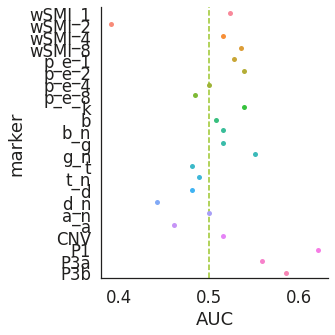

In [11]:
AUC = []
significants = []
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = smw, y = dmw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = smw, y = dmw).pvalue < 0.05:
        significants.append(i)
subject_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants}')


sns.catplot(x = 'AUC', y = 'marker', data = subject_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_1 = 0.6171875
AUC wSMI_2 = 0.21875
AUC wSMI_4 = 0.697265625
AUC wSMI_8 = 0.7265625
AUC p_e_1 = 0.544921875
AUC p_e_2 = 0.56640625
AUC p_e_4 = 0.59375
AUC p_e_8 = 0.68359375
AUC k = 0.5625
AUC b = 0.56640625
AUC b_n = 0.60546875
AUC g = 0.5859375
AUC g_n = 0.5625
AUC t = 0.59375
AUC t_n = 0.60546875
AUC d = 0.60546875
AUC d_n = 0.58984375
AUC a_n = 0.59765625
AUC a = 0.62109375
AUC CNV = 0.40625
AUC P1 = 0.640625
AUC P3a = 0.61328125
AUC P3b = 0.60546875
Index(['dMW', 'sMW'], dtype='object')


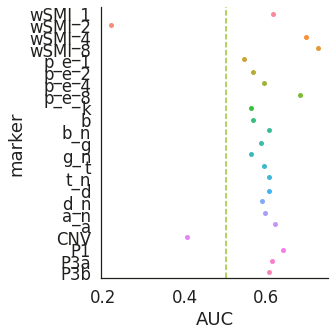

In [12]:
AUC = []
for i in df_mw.drop('mind', axis = 1).columns:
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# By Segment Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [10]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind  = (df_mind
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_':'mind2'})
            .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
           )

In [11]:
AUC = []
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = ot, y = mw).pvalue 
        
segment_mind_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
segment_mind_roc = (segment_mind_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05'])
                   )
           )
segment_mind_roc.to_csv('Data/univariate_roc_mind_segment.csv')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

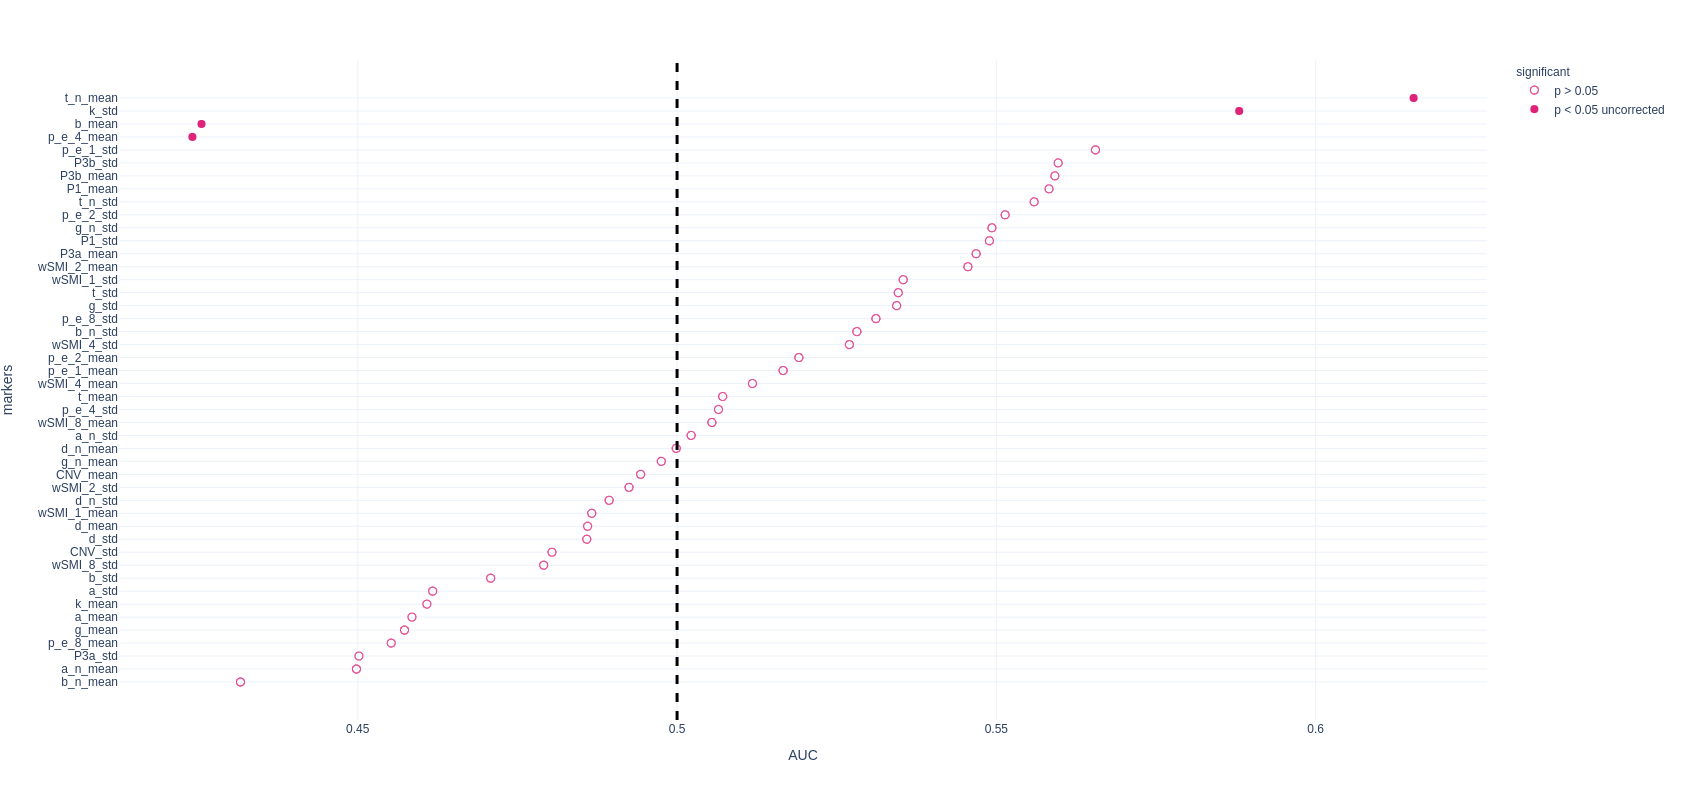

In [186]:
segment_mind_roc = pd.read_csv('Data/univariate_roc_mind_segment.csv')
fig = px.scatter(segment_mind_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [pink, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.update_traces(marker=dict(size = 8))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

AUC wSMI_1_mean = 0.44722222222222224
p_value = 0.8111888111888111
AUC wSMI_1_std = 0.4615277777777778
p_value = 0.7472527472527473
AUC wSMI_2_mean = 0.4240586419753087
p_value = 0.9040959040959041
AUC wSMI_2_std = 0.4870679012345679
p_value = 0.6013986013986014
AUC wSMI_4_mean = 0.4975154320987654
p_value = 0.5064935064935064
AUC wSMI_4_std = 0.3557098765432099
p_value = 0.993006993006993
AUC wSMI_8_mean = 0.46939814814814823
p_value = 0.6993006993006993
AUC wSMI_8_std = 0.5088888888888888
p_value = 0.43956043956043955
AUC p_e_1_mean = 0.4757407407407407
p_value = 0.6503496503496503
AUC p_e_1_std = 0.5294598765432098
p_value = 0.3016983016983017
AUC p_e_2_mean = 0.5115123456790125
p_value = 0.4175824175824176
AUC p_e_2_std = 0.467067901234568
p_value = 0.6893106893106893
AUC p_e_4_mean = 0.5793981481481482
p_value = 0.08091908091908091
AUC p_e_4_std = 0.4299691358024691
p_value = 0.8761238761238761
AUC p_e_8_mean = 0.42834876543209877
p_value = 0.8861138861138861
AUC p_e_8_std = 0.547

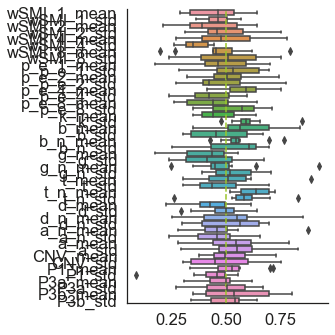

In [17]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mind, label = 'mind2', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mind = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Significant', 'Not significant'))
           )
svc_mind.to_csv('Data/univariate_svc_mind_segment.csv')

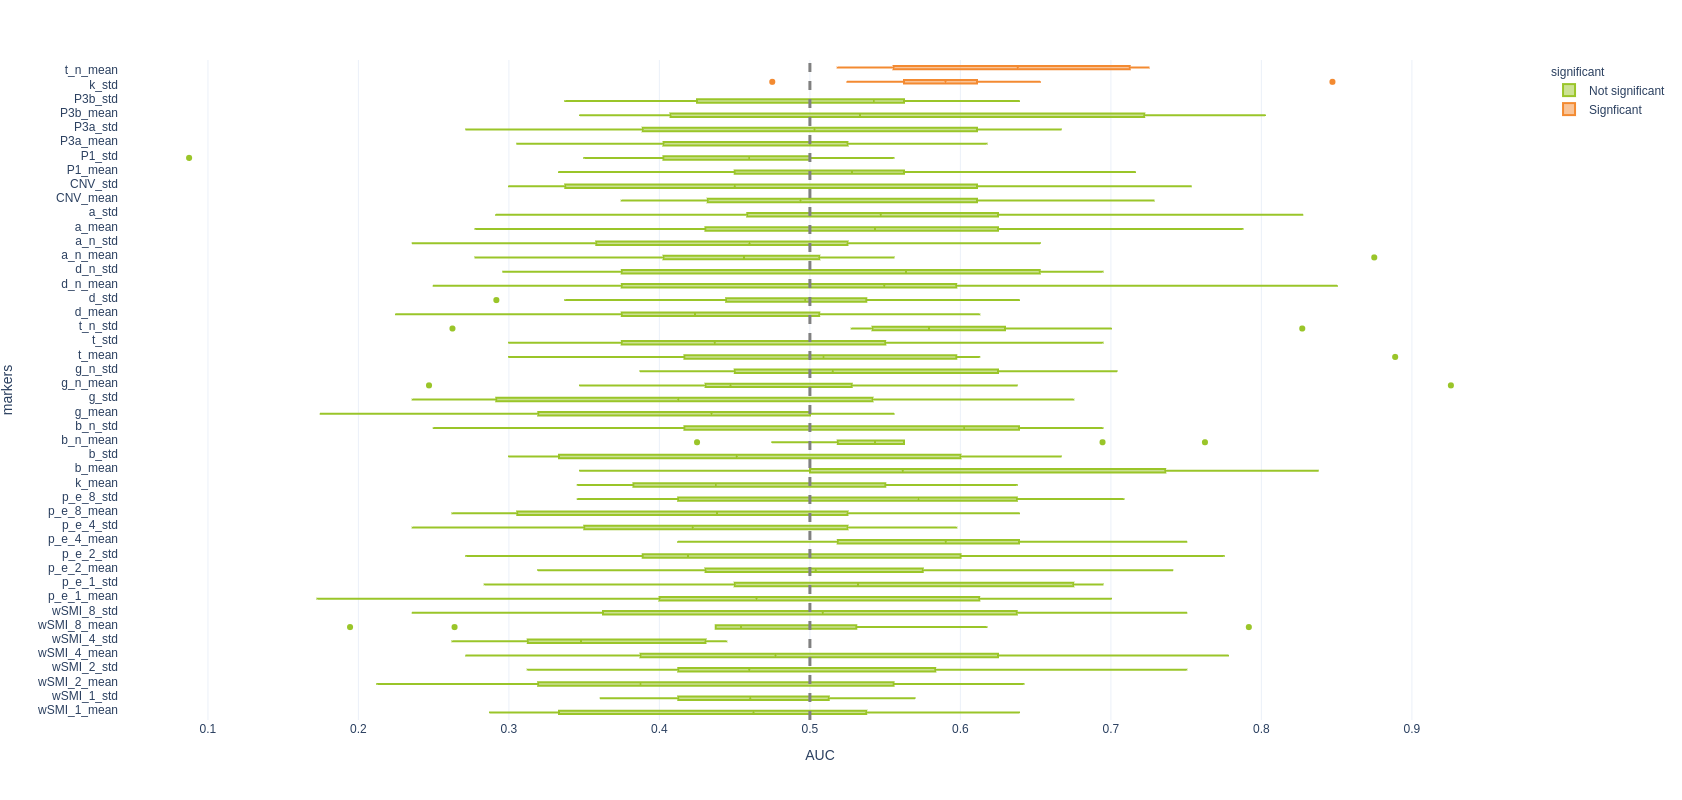

In [42]:
svc_mind = pd.read_csv('Data/univariate_svc_mind_segment.csv')

fig = px.box(svc_mind, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mind_segment.plotly')

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [86]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

df_mw.columns = df_mw.columns.map("_".join)

df_mw  = (df_mw
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
            .drop(['participant', 'probe', 'segment'], axis = 1) 
           )

In [146]:
AUC = []
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = smw, y =dmw).pvalue 
        
segment_mw_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
segment_mw_roc = (segment_mw_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(
                    p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                    significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                 (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                   )
           )

segment_mw_roc.to_csv('Data/univariate_roc_mw_segment.csv')

AUC wSMI_1_mean = 0.5229930069930069 MannwhitneyuResult(statistic=34106.0, pvalue=0.1791005493748133)
AUC wSMI_1_std = 0.4951888111888112 MannwhitneyuResult(statistic=35406.0, pvalue=0.42385794707144653)
AUC wSMI_2_mean = 0.4851328671328671 MannwhitneyuResult(statistic=34687.0, pvalue=0.27625927975150266)
AUC wSMI_2_std = 0.5002517482517483 MannwhitneyuResult(statistic=35732.0, pvalue=0.4960970620590859)
AUC wSMI_4_mean = 0.5164055944055944 MannwhitneyuResult(statistic=34577.0, pvalue=0.2560775019227408)
AUC wSMI_4_std = 0.45586013986013985 MannwhitneyuResult(statistic=32594.0, pvalue=0.03885912993701689)
AUC wSMI_8_mean = 0.4661958041958042 MannwhitneyuResult(statistic=33333.0, pvalue=0.0883567299065594)
AUC wSMI_8_std = 0.4668111888111888 MannwhitneyuResult(statistic=33377.0, pvalue=0.09236263495139468)
AUC p_e_1_mean = 0.5586013986013987 MannwhitneyuResult(statistic=31560.0, pvalue=0.009586787928567014)
AUC p_e_1_std = 0.47665734265734266 MannwhitneyuResult(statistic=34081.0, pvalue

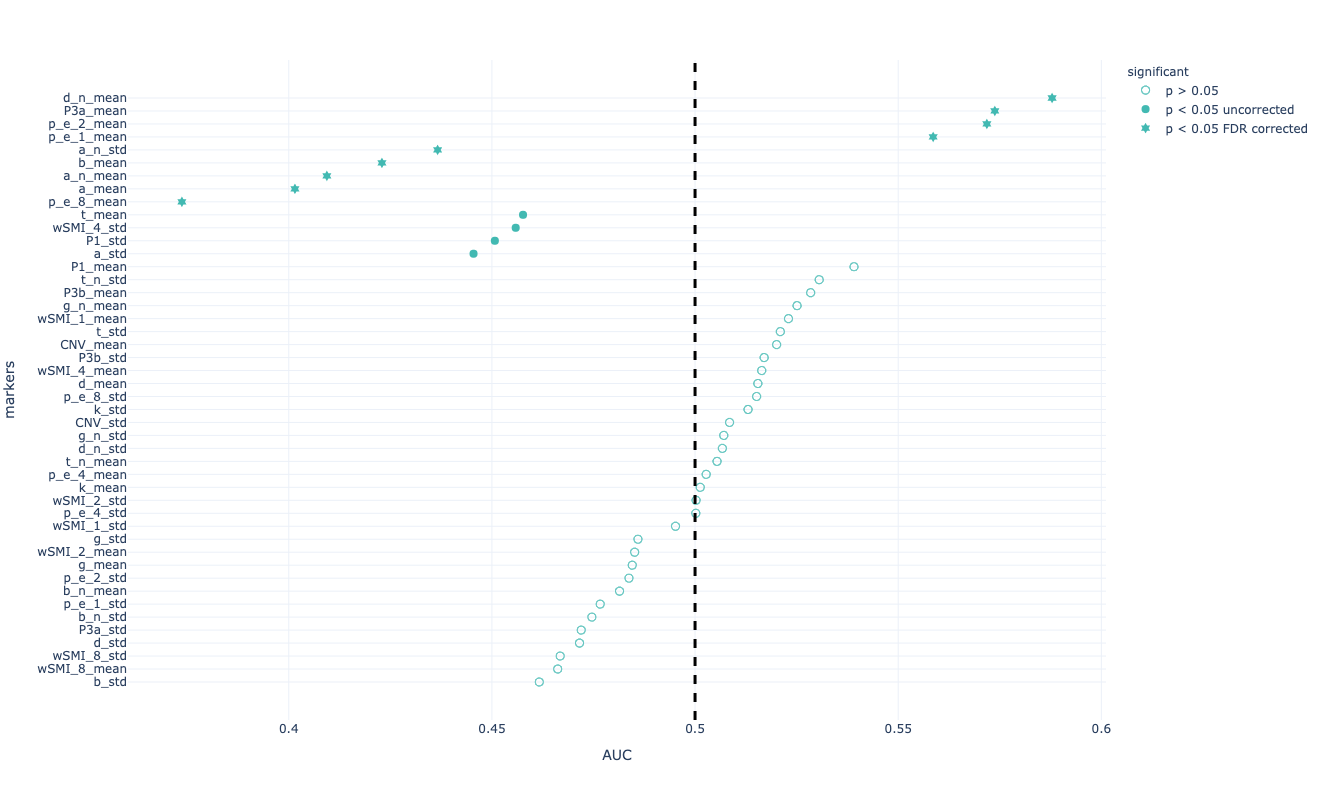

In [185]:
segment_mw_roc = pd.read_csv('Data/univariate_roc_mw_segment.csv')
fig = px.scatter(segment_mw_roc.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white", symbol = 'significant', 
                 symbol_sequence = ['circle-open','circle','hexagram' ],
#                  color = 'significant',
                 color_discrete_sequence = [lblue, green,orange, pink], 
                 
                 category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")

fig.update_traces(marker=dict(size = 8))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_segment.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

In [31]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mw, label = 'mind', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mw = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
svc_mw.to_csv('Data/univariate_svc_mw.csv')

AUC wSMI_1_mean = 0.5164384236453202
p_value = 0.3046953046953047
AUC wSMI_1_std = 0.5066699507389163
p_value = 0.43756243756243757
AUC wSMI_2_mean = 0.4546650246305419
p_value = 0.9460539460539461
AUC wSMI_2_std = 0.4655862068965518
p_value = 0.8731268731268731
AUC wSMI_4_mean = 0.4703743842364532
p_value = 0.8541458541458542
AUC wSMI_4_std = 0.536320197044335
p_value = 0.1108891108891109
AUC wSMI_8_mean = 0.5215566502463054
p_value = 0.22277722277722278
AUC wSMI_8_std = 0.5432315270935961
p_value = 0.07492507492507493
AUC p_e_1_mean = 0.5558817733990148
p_value = 0.017982017982017984
AUC p_e_1_std = 0.4902463054187193
p_value = 0.6083916083916084
AUC p_e_2_mean = 0.5701330049261084
p_value = 0.006993006993006993
AUC p_e_2_std = 0.456103448275862
p_value = 0.936063936063936
AUC p_e_4_mean = 0.5243990147783251
p_value = 0.1998001998001998
AUC p_e_4_std = 0.4950147783251232
p_value = 0.5884115884115884
AUC p_e_8_mean = 0.6340886699507389
p_value = 0.000999000999000999
AUC p_e_8_std = 0.

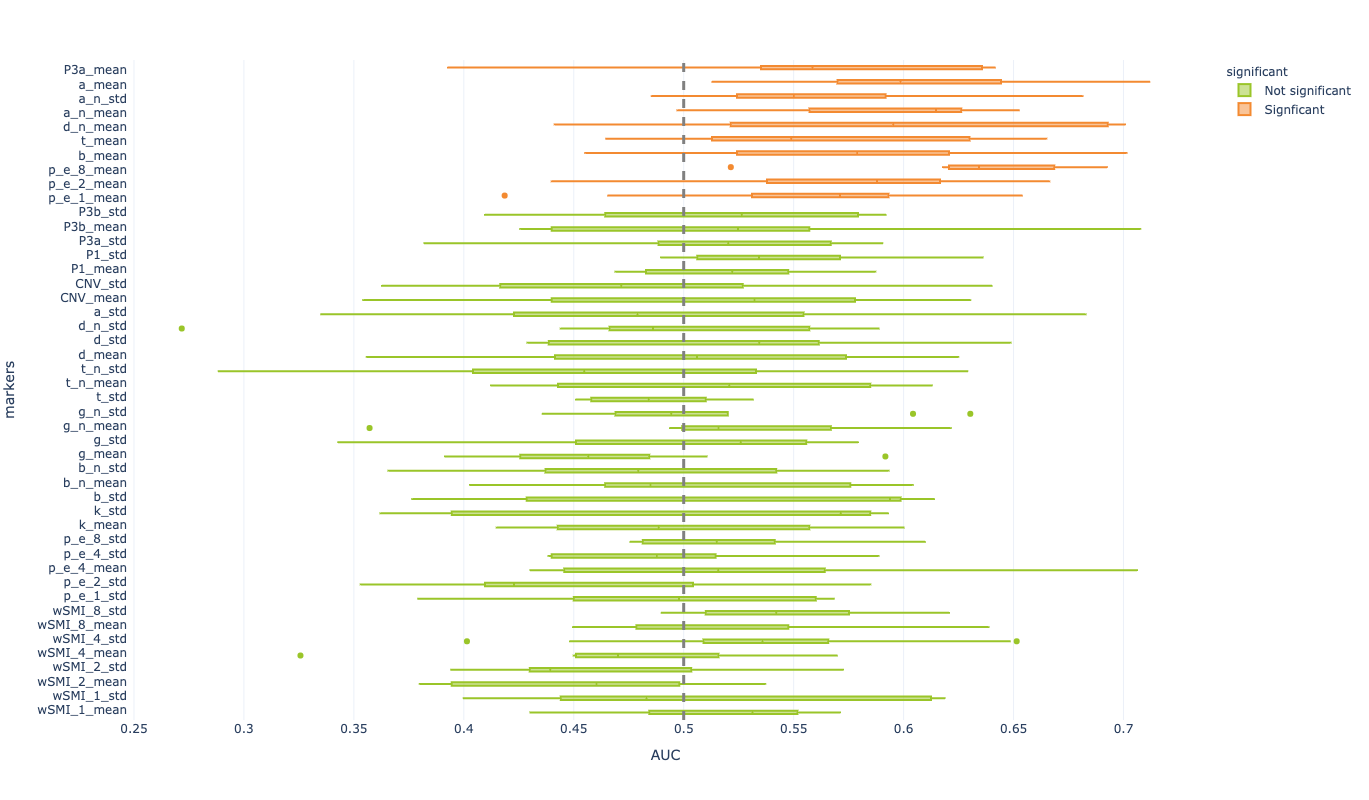

In [41]:
pd.read_csv('Data/univariate_svc_mw.csv')

fig = px.box(svc_mw, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)


fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mw_segment.plotly')


# By Trial Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [60]:
agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also
)

In [45]:
AUC = []
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = ot, y = mw).pvalue 
        
trial_mind_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
trial_mind_roc = (trial_mind_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
trial_mind_roc.to_csv('Data/univariate_roc_mind_trial.csv')

AUC wSMI_1 = 0.48820214362836745 MannwhitneyuResult(statistic=37077.0, pvalue=0.3162385298816914)
AUC wSMI_2 = 0.5092302425407527 MannwhitneyuResult(statistic=37272.0, pvalue=0.35416376749552436)
AUC wSMI_4 = 0.5070444789719011 MannwhitneyuResult(statistic=37438.0, pvalue=0.38764946359098684)
AUC wSMI_8 = 0.5010533800331815 MannwhitneyuResult(statistic=37893.0, pvalue=0.48306715155264507)
AUC p_e_1 = 0.5197508756221525 MannwhitneyuResult(statistic=36473.0, pvalue=0.21162068001481632)
AUC p_e_2 = 0.5208700919074079 MannwhitneyuResult(statistic=36388.0, pvalue=0.1987192266792946)
AUC p_e_4 = 0.43649435124957203 MannwhitneyuResult(statistic=33150.0, pvalue=0.005005281175942722)
AUC p_e_8 = 0.47246727938271926 MannwhitneyuResult(statistic=35882.0, pvalue=0.13211798005505238)
AUC k = 0.4776617596713454 MannwhitneyuResult(statistic=36276.5, pvalue=0.18253238159284724)
AUC b = 0.4386801148184236 MannwhitneyuResult(statistic=33316.0, pvalue=0.006444680745797501)
AUC b_n = 0.43046375055960817 M

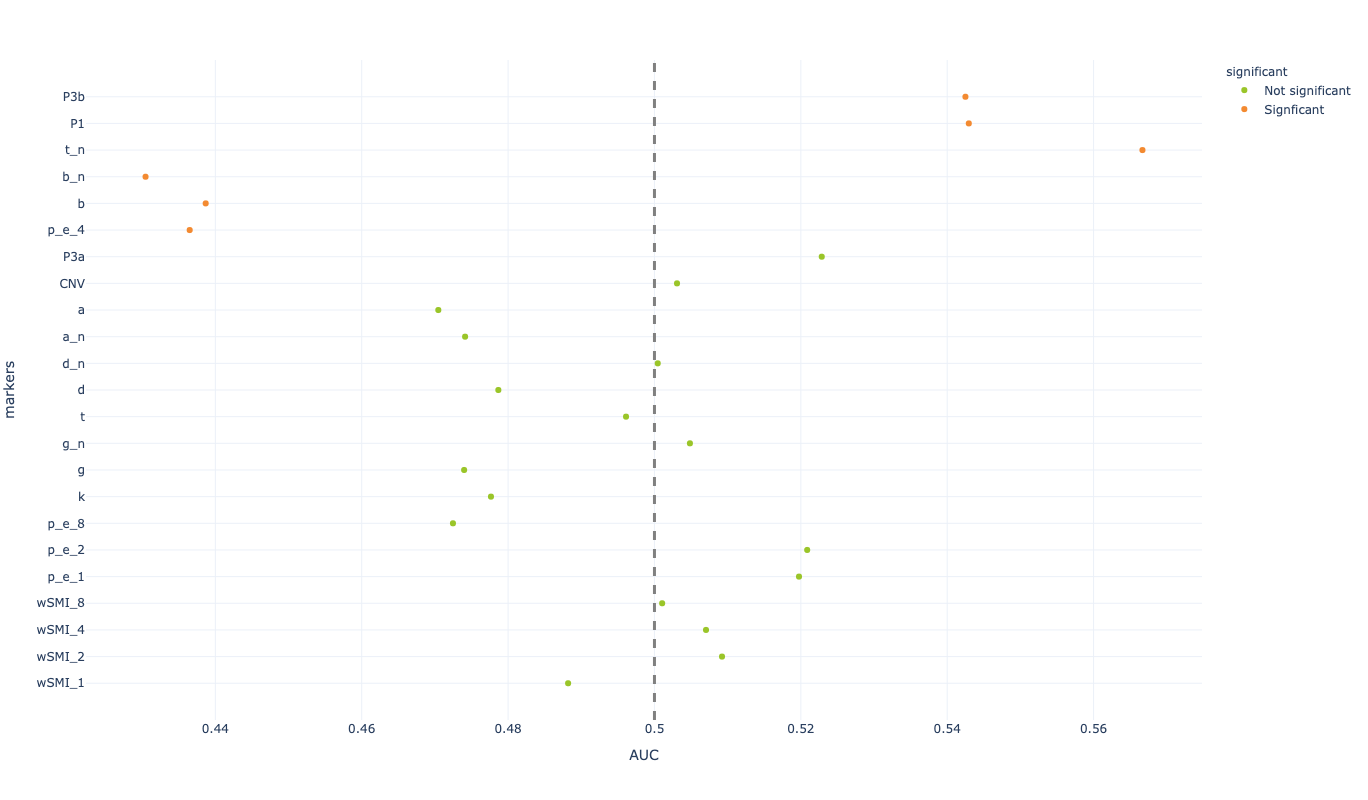

In [47]:
trial_mind_roc = pd.read_csv('Data/univariate_roc_mind_trial.csv')
fig = px.scatter(trial_mind_roc,x = 'AUC', y = 'markers', template = "plotly_white", color = 'significant',color_discrete_sequence = [green,orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mind_trial.plotly')

In [48]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mind.drop('mind2', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mind, label = 'mind2', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mind_trial = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
svc_mind_trial.to_csv('Data/univariate_svc_mind_trial.csv')

AUC wSMI_1 = 0.4904762157382847
p_value = 0.6313686313686314
AUC wSMI_2 = 0.5092984969053934
p_value = 0.3516483516483517
AUC wSMI_4 = 0.4992732095490716
p_value = 0.5194805194805194
AUC wSMI_8 = 0.4958969053934571
p_value = 0.5694305694305695
AUC p_e_1 = 0.5071076923076923
p_value = 0.35764235764235763
AUC p_e_2 = 0.5026443854995579
p_value = 0.46853146853146854
AUC p_e_4 = 0.540705216622458
p_value = 0.07892107892107893
AUC p_e_8 = 0.4901211317418214
p_value = 0.6093906093906094
AUC k = 0.5052061892130858
p_value = 0.4275724275724276
AUC b = 0.55764350132626
p_value = 0.016983016983016984
AUC b_n = 0.5590843501326261
p_value = 0.013986013986013986
AUC g = 0.4571798408488063
p_value = 0.945054945054945
AUC g_n = 0.46338638373121127
p_value = 0.8831168831168831
AUC t = 0.4609236074270557
p_value = 0.936063936063936
AUC t_n = 0.48273492484526975
p_value = 0.6973026973026973
AUC d = 0.5066611847922193
p_value = 0.3866133866133866
AUC d_n = 0.5275541998231653
p_value = 0.17882117882117882

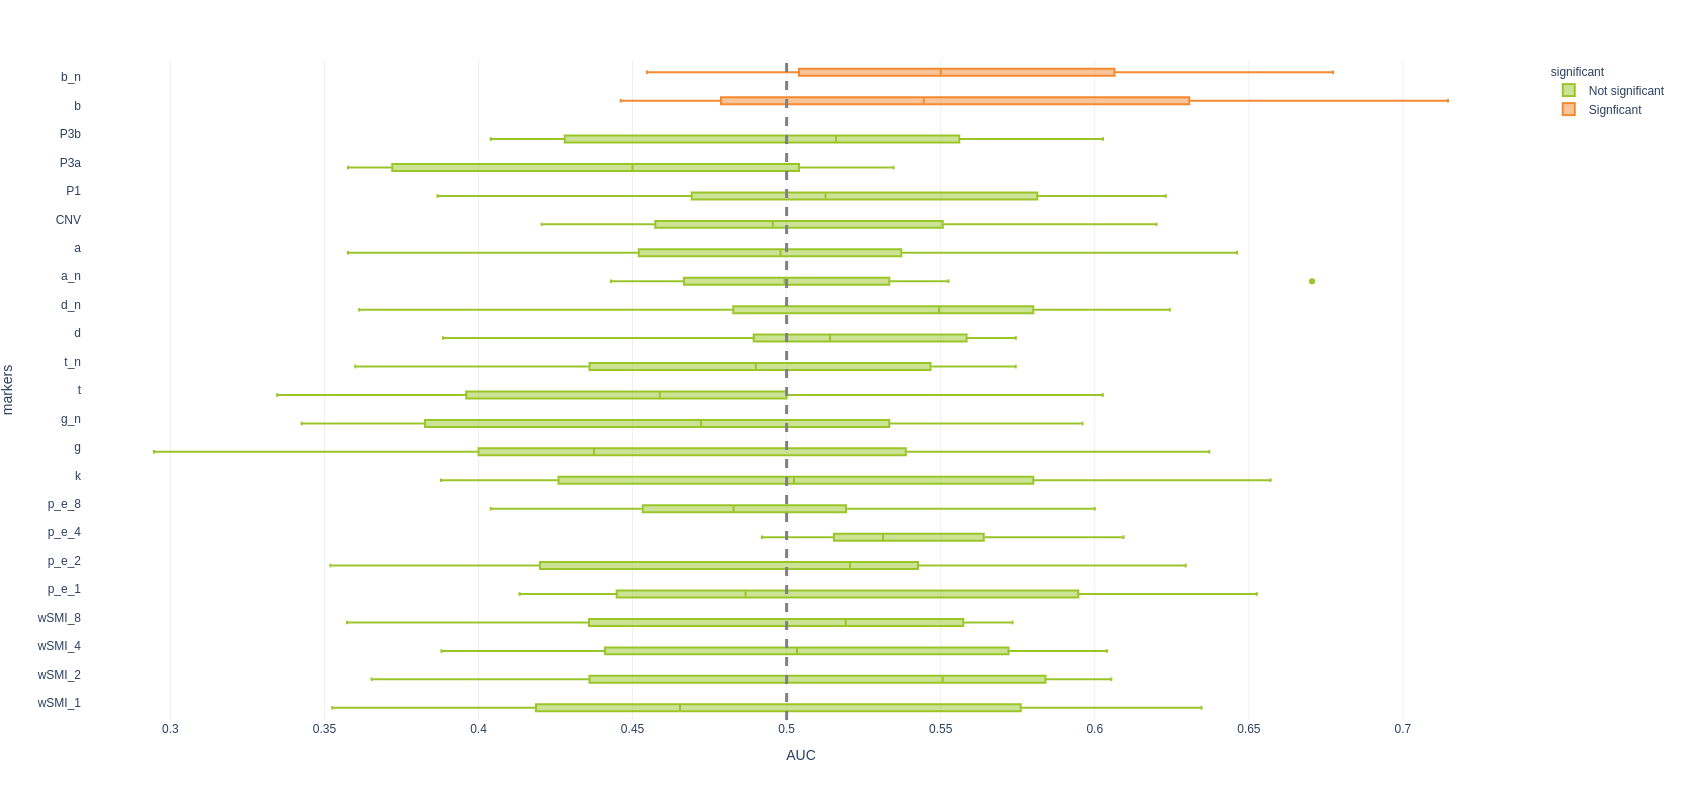

In [49]:
svc_mind_trial = pd.read_csv('Data/univariate_svc_mind_trial.csv')

fig = px.box(svc_mind_trial, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mind_trial.plotly')

In [ ]:
n_estimators = 2000
AUC = pd.DataFrame()
for i in  df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [69]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe', 'segment'], axis = 1)
)

In [71]:
len(df_mw.query("mind == 'dMW'"))

841

In [51]:
AUC = []
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    pvalues[i] = mannwhitneyu(x = smw, y =dmw).pvalue 
        
trial_mw_roc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
trial_mw_roc = (trial_mw_roc
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
trial_mw_roc.to_csv('Data/univariate_roc_mw_trial.csv')

AUC wSMI_1 = 0.5217113364163242 MannwhitneyuResult(statistic=294038.0, pvalue=0.06853351172097825)
AUC wSMI_2 = 0.49055827291788323 MannwhitneyuResult(statistic=301581.0, pvalue=0.2589640889962029)
AUC wSMI_4 = 0.5194665981316621 MannwhitneyuResult(statistic=295418.0, pvalue=0.09125345404214186)
AUC wSMI_8 = 0.4782057058644601 MannwhitneyuResult(statistic=293987.0, pvalue=0.0677862151892067)
AUC p_e_1 = 0.5639351888752072 MannwhitneyuResult(statistic=268080.0, pvalue=5.977152201179307e-06)
AUC p_e_2 = 0.5671005951809698 MannwhitneyuResult(statistic=266134.0, pvalue=2.161711648814405e-06)
AUC p_e_4 = 0.5028311354959815 MannwhitneyuResult(statistic=305645.0, pvalue=0.42315487748533986)
AUC p_e_8 = 0.4061772594998788 MannwhitneyuResult(statistic=249706.0, pvalue=6.584398184006263e-11)
AUC k = 0.5052190165118393 MannwhitneyuResult(statistic=304177.0, pvalue=0.3604114293415178)
AUC b = 0.4343438451065519 MannwhitneyuResult(statistic=267022.0, pvalue=3.45768938605754e-06)
AUC b_n = 0.4848049

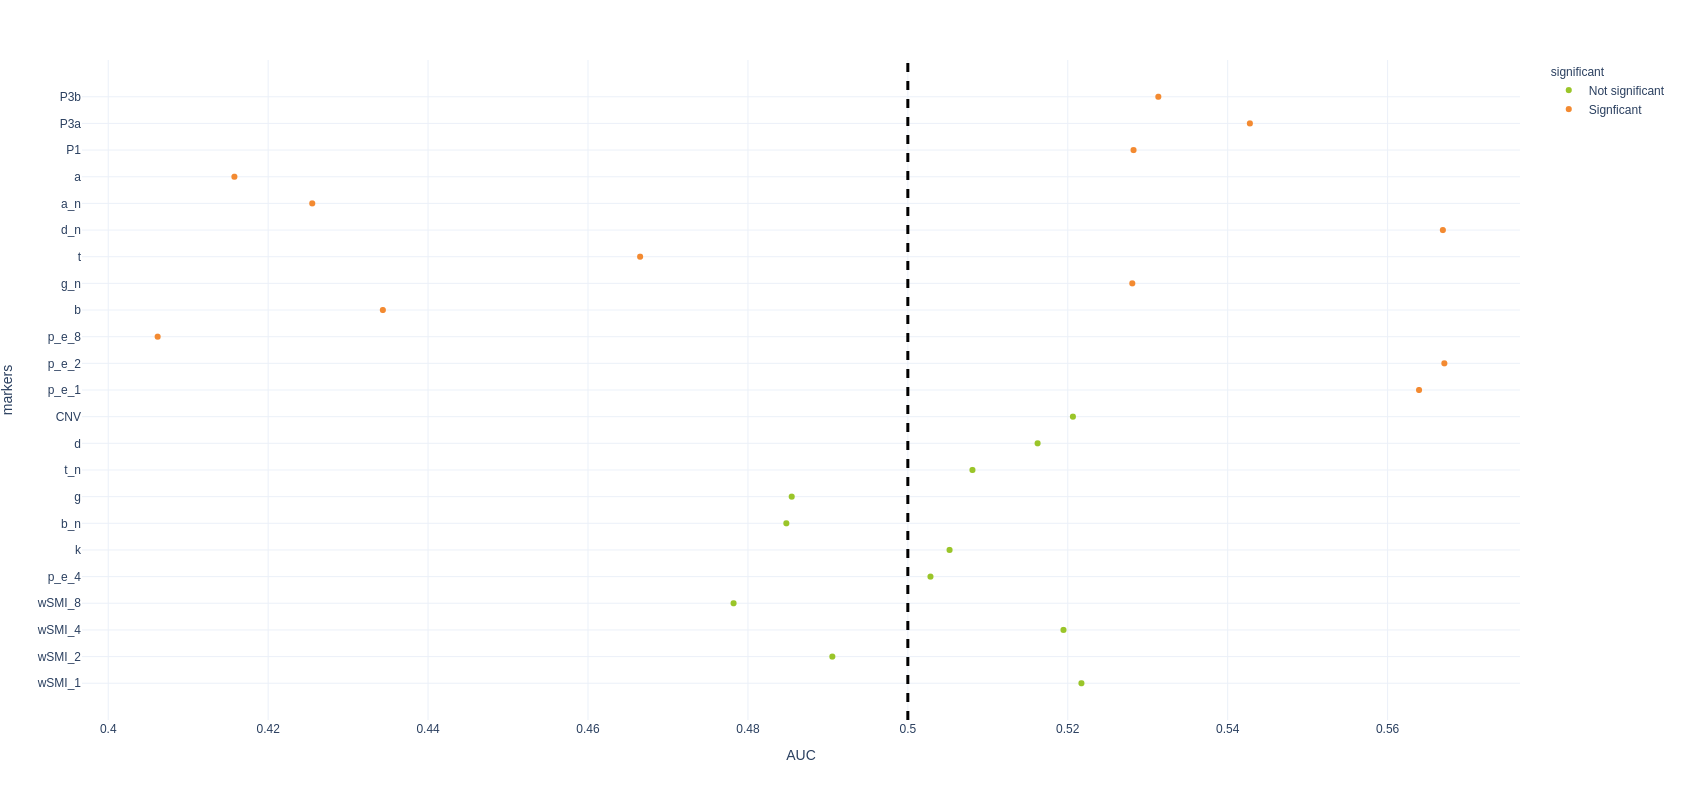

In [52]:
trial_mind_roc = pd.read_csv('Data/univariate_roc_mw_trial.csv')
fig = px.scatter(trial_mw_roc,x = 'AUC', y = 'markers', template = "plotly_white", color = 'significant',color_discrete_sequence = [green,orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
    
)
fig.show()
pio.write_json(fig, 'Figs/univariate_roc_mw_trial.plotly')
# fig.write_image('Figs/univariate_roc_mw_segment.png')

In [53]:
AUC = pd.DataFrame()
pvalues = {}
for i in df_mw.drop('mind', axis = 1).columns:
    

    AUC[i], pvalues[i] =  univariate_classifier(
    data= df_mw, label = 'mind', feature = i, model = 'SVM', grid_search=False, permutation=True, n_permutations = 1000
)

    
p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
svc_mw_trial = (AUC.reset_index().melt(id_vars = ['index'], var_name = 'markers', value_name = 'AUC')
            .drop('index', axis = 1)
            .merge(p_df, on = 'markers', how = 'inner')
            .assign(significant = lambda df: np.where(df.p_value< 0.05, 'Signficant', 'Not significant'))
           )
svc_mw_trial.to_csv('Data/univariate_svc_mw_trial.csv')

AUC wSMI_1 = 0.5018059811855137
p_value = 0.46853146853146854
AUC wSMI_2 = 0.4859879601599989
p_value = 0.8411588411588412
AUC wSMI_4 = 0.497206063839827
p_value = 0.5744255744255744
AUC wSMI_8 = 0.48274134385335027
p_value = 0.8731268731268731
AUC p_e_1 = 0.5641385413847138
p_value = 0.000999000999000999
AUC p_e_2 = 0.5727134804310468
p_value = 0.000999000999000999


KeyboardInterrupt: 

In [ ]:
pd.read_csv('Data/univariate_svc_mw_trial.csv')

fig = px.box(svc_mw_trial, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)


fig.show()
pio.write_json(fig, 'Figs/univariate_svc_mw_trial.plotly')


# Plots

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

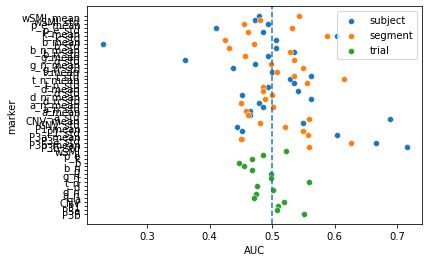

In [135]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mind_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

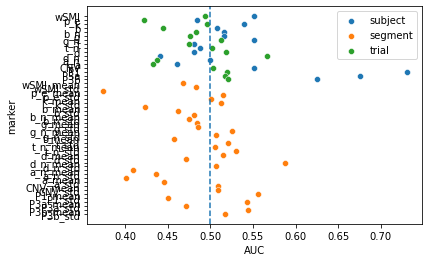

In [136]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mw_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## Comparison of significan markers for Mind and Mw

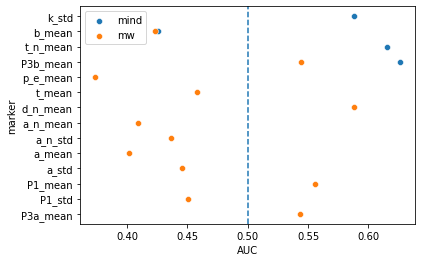

In [134]:
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mind )
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mw )
plt.legend(['mind','mw'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()